In [ ]:

#%% import stuff:

import matplotlib.pyplot as plt
import numpy as np
import pickle

import torch
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


temp=pickle.load(open('/content/drive/MyDrive/starData.p','rb'))
X=temp['X']
y=temp['y']


Mounted at /content/drive


tensor([6.0000, 2.5596])


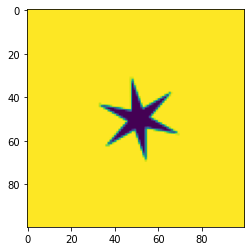

In [ ]:
idx=125
plt.imshow(np.squeeze(X[125,:,:,:],axis=0))
print(y[idx,:])

In [ ]:
#%% make datasets & loaders

#split in val and train:
nData=X.shape[0]
nVal=300
valIdx=range(nVal)
trainIdx=range(nVal+1,nData)

#datasets:
trainDataset=torch.utils.data.TensorDataset(X[trainIdx,:,:,:],y[trainIdx,:])
valDataset=torch.utils.data.TensorDataset(X[valIdx,:,:,:],y[valIdx,:])

#dataloaders:
trainLoader=torch.utils.data.DataLoader(trainDataset,batch_size=32,shuffle=True)
valLoader=torch.utils.data.DataLoader(valDataset,batch_size=32,shuffle=True)


#%% make network

class simpleCNN(nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()

        self.cnn1=nn.Conv2d(in_channels=1,out_channels=1,kernel_size=5,stride=1,padding=2)
        self.cnn2=nn.Conv2d(in_channels=1,out_channels=1,kernel_size=5,stride=2,padding=2)

        self.fc1=nn.Linear(50*50, 80, bias=True)
        self.leakRelu1=nn.LeakyReLU()
        self.fc2=nn.Linear(80, 2, bias=True)
        self.leakRelu2=nn.LeakyReLU()

    def forward(self,x):
        x=self.cnn1(x)
        x=self.cnn2(x)
        x=torch.reshape(x,(-1,50*50))
        x=self.fc1(x)
        x=self.leakRelu1(x)
        x=self.fc2(x)

        return x

#testing:
testData=torch.rand((1,1,100,100))
testNet=simpleCNN()
testNet.forward(testData)



tensor([[ 0.0182, -0.0277]], grad_fn=<AddmmBackward>)

0
tensor(102.7954, grad_fn=<DivBackward0>)
tensor(109.9903, grad_fn=<DivBackward0>)
1
tensor(31.6941, grad_fn=<DivBackward0>)
tensor(36.5077, grad_fn=<DivBackward0>)
2
tensor(25.1733, grad_fn=<DivBackward0>)
tensor(29.4698, grad_fn=<DivBackward0>)
3
tensor(21.1627, grad_fn=<DivBackward0>)
tensor(25.7931, grad_fn=<DivBackward0>)
4
tensor(17.8398, grad_fn=<DivBackward0>)
tensor(21.5467, grad_fn=<DivBackward0>)
5
tensor(15.0624, grad_fn=<DivBackward0>)
tensor(18.4827, grad_fn=<DivBackward0>)
6
tensor(13.2852, grad_fn=<DivBackward0>)
tensor(15.9582, grad_fn=<DivBackward0>)
7
tensor(13.2471, grad_fn=<DivBackward0>)
tensor(15.7788, grad_fn=<DivBackward0>)
8
tensor(11.2493, grad_fn=<DivBackward0>)
tensor(13.3945, grad_fn=<DivBackward0>)
9
tensor(8.8297, grad_fn=<DivBackward0>)
tensor(10.8858, grad_fn=<DivBackward0>)
10
tensor(8.5920, grad_fn=<DivBackward0>)
tensor(10.6543, grad_fn=<DivBackward0>)
11
tensor(7.3080, grad_fn=<DivBackward0>)
tensor(9.3701, grad_fn=<DivBackward0>)
12
tensor(7.0457

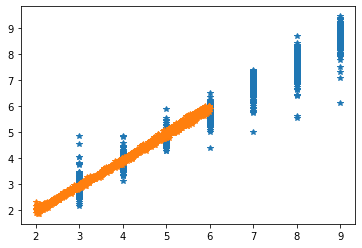

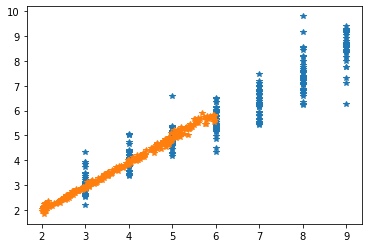

In [ ]:

#%% train & validate

nEpoch=30

net=simpleCNN()
optimizer=torch.optim.Adam(net.parameters())

#%% define loss'es
loss1=nn.SmoothL1Loss(reduction='sum',beta=0.05)
loss2=nn.SmoothL1Loss(reduction='sum',beta=0.05)
loss_fn = lambda pred,target : 0.5*loss1(pred[:,0],target[:,0].float())+0.5*loss2(pred[:,1],target[:,1])

# equivalently, define the loss as a usual function object instead of a lambda function
def loss_equivalent(pred, target):
  loss = loss1(pred[:,0],target[:,0].float())
  loss += loss2(pred[:,1],target[:,1])
  return 0.5*loss

for iEpoch in range(nEpoch):
    print(iEpoch)
    totLoss=0
    for xbatch,ybatch in trainLoader:

        ypred=net(xbatch)
        loss = loss_fn(ypred,ybatch)
        totLoss+=loss
        net.zero_grad()

        loss.backward()

        optimizer.step()

    print(totLoss/len(trainLoader))

    for xbatch,ybatch in valLoader:

        ypred=net(xbatch)
        loss = loss_fn(ypred,ybatch)
        totLoss+=loss

    print(totLoss/len(trainLoader))


trainy=np.zeros((0,2))
trainRes=np.zeros((0,2))

for xbatch,ybatch in trainLoader:

        ypred=net(xbatch)
        trainRes=np.concatenate((trainRes,ypred.detach().numpy()),axis=0)
        trainy=np.concatenate((trainy,ybatch.detach().numpy()),axis=0)

valy=np.zeros((0,2))
valRes=np.zeros((0,2))

for xbatch,ybatch in valLoader:

        ypred=net(xbatch)
        valRes=np.concatenate((valRes,ypred.detach().numpy()),axis=0)
        valy=np.concatenate((valy,ybatch.detach().numpy()),axis=0)


plt.close('all')
plt.plot(trainy,trainRes,'*')

plt.figure()
plt.plot(valy,valRes,'*')
